# Model Evaluation
**Group J - Diabetes Prediction Project**

This notebook evaluates the trained model on both imbalanced (original) and balanced test sets.

## Part 0. Import Libraries

In [1]:
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, roc_auc_score, f1_score, 
                             precision_score, recall_score, confusion_matrix, 
                             classification_report, roc_curve, precision_recall_curve)
from sklearn.model_selection import train_test_split


plt.style.use('ggplot')

## Part 1. Evaluation Function

In [2]:
def evaluate_model(model_path, test_data, scaler_path=None):
    """
    Evaluate model on test data and return metrics + predictions.
    """
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path) if scaler_path else None
    
    y_true = test_data["Outcome"].astype(int)
    X = test_data.drop(columns=["Outcome", "subject_id"], errors="ignore")
    X_scaled = scaler.transform(X) if scaler else X.values
    
    y_pred = model.predict(X_scaled)
    y_proba = model.predict_proba(X_scaled)[:, 1]
    
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_proba),
        "F1-Score": f1_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "Specificity": recall_score(y_true, y_pred, pos_label=0)
    }
    
    print("EVALUATION METRICS")
    print("=" * 35)
    for name, value in metrics.items():
        print(f"{name:.<20} {value:.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=["No Diabetes", "Diabetes"]))
    
    return {"metrics": metrics, "y_true": y_true.values, "y_pred": y_pred, "y_proba": y_proba}

## Part 2. Load and Prepare Data

In [4]:
# Load cleaned data
df = pd.read_csv('../data/diabetes_cleaned.csv')
print(f"Cleaned data: {len(df)} samples")

# Train-test split
y = df["Outcome"]
X = df.drop(columns=["Outcome", "subject_id"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create imbalanced test DataFrame (original distribution)
test_df_imbalanced = X_test.copy()
test_df_imbalanced['Outcome'] = y_test.values

print(f"\nImbalanced test set: {len(test_df_imbalanced)} samples")
print(test_df_imbalanced['Outcome'].value_counts())

Cleaned data: 391 samples

Imbalanced test set: 79 samples
Outcome
0    53
1    26
Name: count, dtype: int64


In [5]:
# Create balanced test set (equal samples from each class)
test_diabetes = test_df_imbalanced[test_df_imbalanced['Outcome'] == 1]
test_no_diabetes = test_df_imbalanced[test_df_imbalanced['Outcome'] == 0]

# Sample equal number from majority class
n_minority = len(test_diabetes)
test_no_diabetes_sampled = test_no_diabetes.sample(n=n_minority, random_state=42)

# Combine into balanced test set
test_df_balanced = pd.concat([test_diabetes, test_no_diabetes_sampled])
test_df_balanced = test_df_balanced.sample(frac=1, random_state=42)  # Shuffle

print(f"Balanced test set: {len(test_df_balanced)} samples")
print(test_df_balanced['Outcome'].value_counts())

Balanced test set: 52 samples
Outcome
1    26
0    26
Name: count, dtype: int64


## Part 3. Evaluation on Imbalanced Test Set

In [6]:
print("=" * 50)
print("IMBALANCED TEST SET (Original Distribution)")
print("=" * 50)
results_imbalanced = evaluate_model(
    model_path='../models/model.pkl',
    test_data=test_df_imbalanced,
    scaler_path='../models/scaler.pkl'
)

IMBALANCED TEST SET (Original Distribution)
EVALUATION METRICS
Accuracy............ 0.8481
ROC-AUC............. 0.8853
F1-Score............ 0.7600
Precision........... 0.7917
Recall.............. 0.7308
Specificity......... 0.9057

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.87      0.91      0.89        53
    Diabetes       0.79      0.73      0.76        26

    accuracy                           0.85        79
   macro avg       0.83      0.82      0.82        79
weighted avg       0.85      0.85      0.85        79



/Users/mac/miniconda3/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.4.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/mac/miniconda3/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.4.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Part 4. Evaluation on Balanced Test Set

In [7]:
print("=" * 50)
print("BALANCED TEST SET (50/50 Distribution)")
print("=" * 50)
results_balanced = evaluate_model(
    model_path='../models/model.pkl',
    test_data=test_df_balanced,
    scaler_path='../models/scaler.pkl'
)

BALANCED TEST SET (50/50 Distribution)
EVALUATION METRICS
Accuracy............ 0.8077
ROC-AUC............. 0.8935
F1-Score............ 0.7917
Precision........... 0.8636
Recall.............. 0.7308
Specificity......... 0.8846

Classification Report:
              precision    recall  f1-score   support

 No Diabetes       0.77      0.88      0.82        26
    Diabetes       0.86      0.73      0.79        26

    accuracy                           0.81        52
   macro avg       0.82      0.81      0.81        52
weighted avg       0.82      0.81      0.81        52



/Users/mac/miniconda3/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.4.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/mac/miniconda3/lib/python3.10/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.4.2 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


## Part 5. Comparison of Results

In [8]:
# Create comparison table
comparison = pd.DataFrame({
    'Metric': list(results_imbalanced['metrics'].keys()),
    'Imbalanced': [f"{v:.4f}" for v in results_imbalanced['metrics'].values()],
    'Balanced': [f"{v:.4f}" for v in results_balanced['metrics'].values()]
})
print("\nMETRICS COMPARISON")
print("=" * 45)
print(comparison.to_string(index=False))


METRICS COMPARISON
     Metric Imbalanced Balanced
   Accuracy     0.8481   0.8077
    ROC-AUC     0.8853   0.8935
   F1-Score     0.7600   0.7917
  Precision     0.7917   0.8636
     Recall     0.7308   0.7308
Specificity     0.9057   0.8846


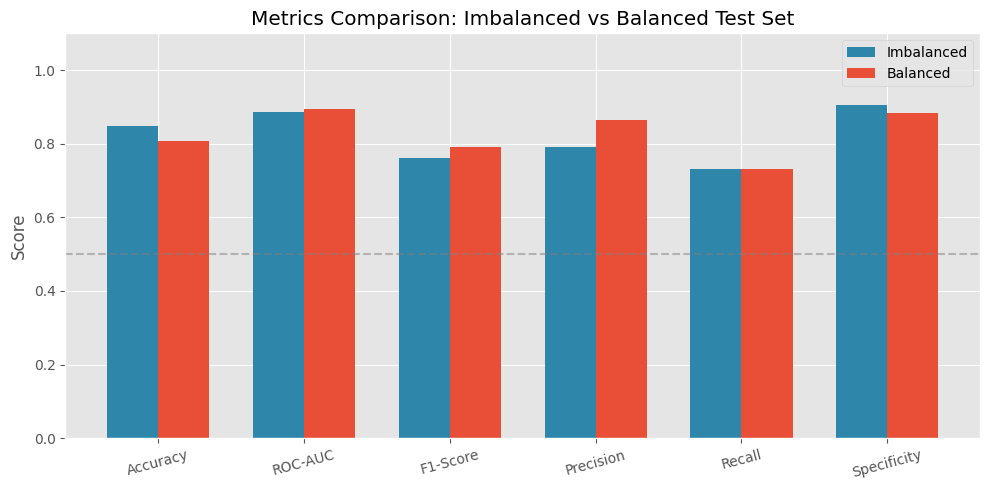

In [9]:
# Plot comparison
fig, ax = plt.subplots(figsize=(10, 5))
x = np.arange(len(results_imbalanced['metrics']))
width = 0.35

bars1 = ax.bar(x - width/2, results_imbalanced['metrics'].values(), width, label='Imbalanced', color='#2E86AB')
bars2 = ax.bar(x + width/2, results_balanced['metrics'].values(), width, label='Balanced', color='#E94F37')

ax.set_ylabel('Score')
ax.set_title('Metrics Comparison: Imbalanced vs Balanced Test Set')
ax.set_xticks(x)
ax.set_xticklabels(results_imbalanced['metrics'].keys(), rotation=15)
ax.legend()
ax.set_ylim(0, 1.1)
ax.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('metrics_comparison.png', dpi=150)
plt.show()

## Part 6. Evaluation Plots

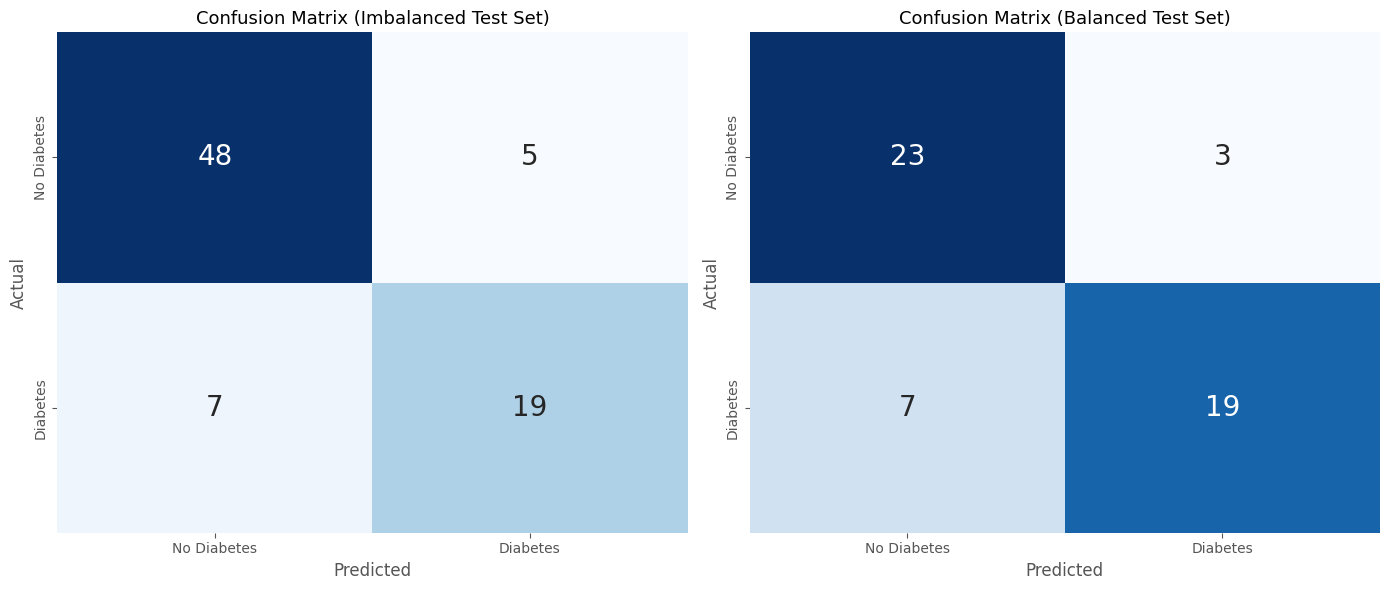

In [10]:
# Confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, results, title in zip(axes, 
                               [results_imbalanced, results_balanced], 
                               ['Imbalanced Test Set', 'Balanced Test Set']):
    cm = confusion_matrix(results['y_true'], results['y_pred'])
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['No Diabetes', 'Diabetes'],
                yticklabels=['No Diabetes', 'Diabetes'],
                annot_kws={'size': 20}, cbar=False)
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('Actual', fontsize=12)
    ax.set_title(f'Confusion Matrix ({title})', fontsize=13)

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=150)
plt.show()

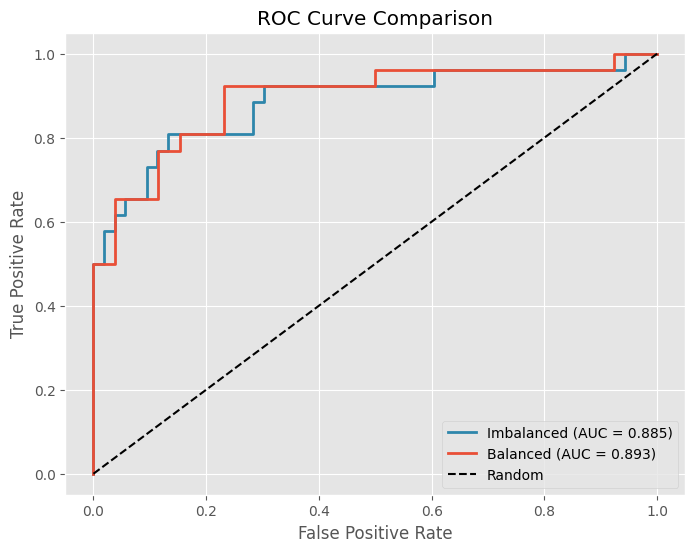

In [11]:
# ROC curves comparison
plt.figure(figsize=(8, 6))

for results, label, color in zip([results_imbalanced, results_balanced],
                                  ['Imbalanced', 'Balanced'],
                                  ['#2E86AB', '#E94F37']):
    fpr, tpr, _ = roc_curve(results['y_true'], results['y_proba'])
    auc = results['metrics']['ROC-AUC']
    plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC = {auc:.3f})", color=color)

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.savefig('roc_curves.png', dpi=150)
plt.show()

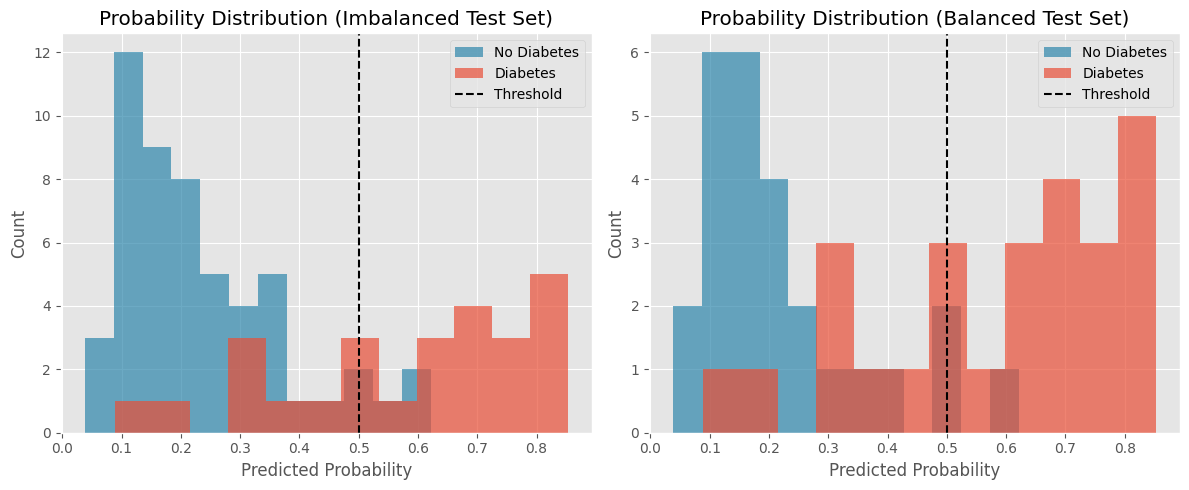

In [12]:
# Probability distributions comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for ax, results, title in zip(axes,
                               [results_imbalanced, results_balanced],
                               ['Imbalanced Test Set', 'Balanced Test Set']):
    ax.hist(results['y_proba'][results['y_true'] == 0], bins=12, alpha=0.7, 
            label='No Diabetes', color='#2E86AB')
    ax.hist(results['y_proba'][results['y_true'] == 1], bins=12, alpha=0.7, 
            label='Diabetes', color='#E94F37')
    ax.axvline(x=0.5, color='black', linestyle='--', label='Threshold')
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Count')
    ax.set_title(f'Probability Distribution ({title})')
    ax.legend()

plt.tight_layout()
plt.savefig('probability_distributions.png', dpi=150)
plt.show()

## Part 7. Summary

**Key Observations:**

1. **Accuracy** is higher on the imbalanced set due to the majority class bias. On the balanced set, accuracy reflects true classification ability.

2. **ROC-AUC** remains relatively stable across both settings, as it measures ranking ability independent of class distribution.

3. **Recall and Specificity** trade off differently depending on class balance - the balanced set provides clearer insight into per-class performance.

4. The **imbalanced evaluation** reflects real-world deployment performance, while the **balanced evaluation** shows the model's intrinsic ability to distinguish between classes.